In [1058]:
from multiprocessing import Pool
from functools import partial
import numpy as np
# from numba import jit

In [1059]:
#TODO: loss of least square regression and binary logistic regression
'''
    pred() takes GBDT/RF outputs, i.e., the "score", as its inputs, and returns predictions.
    g() is the gradient/1st order derivative, which takes true values "true" and scores as input, and returns gradient.
    h() is the heassian/2nd order derivative, which takes true values "true" and scores as input, and returns hessian.
'''
class leastsquare(object):
    '''Loss class for mse. As for mse, pred function is pred=score.'''
    def pred(self,score):
        return score 

    def g(self,true,score):
        return 2*(score - true)

    def h(self,true,score):
        return np.full(len(score), 2.0)

class logistic(object):
    '''Loss class for log loss. As for log loss, pred function is logistic transformation.'''
    def pred(self,score):
        logistic_score = 1/(1 + np.exp(-score))
        return logistic_score

    def g(self,true,score):
        pred = self.pred(score)
        return (pred - true)

    def h(self,true,score):
        pred = self.pred(score)
        return (pred*(1 - pred))
        

In [1060]:
import random

def sample_with_replacement(train, target, sampling_ratio):
    train_sample, target_sample = [], []
    num_to_select = round(len(train) * sampling_ratio)
    while len(train_sample) < num_to_select:
        idx = random.randrange(len(train))
        train_sample.append(train[idx])
        target_sample.append(target[idx])
    return np.array(train_sample), np.array(target_sample)


In [1061]:
# TODO: class of Random Forest
class RF(object):
    '''
    Class of Random Forest
    
    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        loss: Loss function for gradient boosting.
            'mse' for regression task and 'log' for classfication task.
            A child class of the loss class could be passed to implement customized loss.
        max_depth: The maximum depth d_max of a tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf score, also known as lambda.
        gamma: The regularization coefficient for number of tree nodes, also know as gamma.
        rf: rf*m is the size of random subset of features, from which we select the best decision rule.
        num_trees: Number of trees.
    '''
    def __init__(self,
        n_threads = None, loss = 'mse',
        max_depth = 3, min_sample_split = 10, 
        lamda = 1, gamma = 0,
        rf = 0.99, num_trees = 100, sample_size=1.0, parallelize=False):
        
        self.n_threads = n_threads
        self.loss = loss
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.rf = rf
        self.num_trees = num_trees
        self.parallelize = parallelize

        
    def fit(self, train, target):
        # train is n x m 2d numpy array
        # target is n-dim 1d array
        #TODO
        n = len(train)
        m = train.shape[1]

        if self.loss == 'mse':
            self.loss = leastsquare()
        else:
            self.loss = logistic()
            
        self.target_mean = float(np.mean(target))
        self.decision_trees = []
        
        for _ in range(self.num_trees):
            decision_tree = Tree(max_depth = self.max_depth, min_sample_split = self.min_sample_split,
                                lamda = self.lamda, gamma = self.gamma, rf = self.rf, parallelize=self.parallelize)
            training_x, training_y = sample_with_replacement(train, target, 1.0)
            preds = np.full(len(training_x), self.target_mean)
            g = self.loss.g(training_y, preds)
            h = self.loss.h(training_y, preds)
            decision_tree.fit(training_x, g, h)            
            self.decision_trees.append(decision_tree)
        return self

    
    def predict(self, test):
        #TODO
        score = np.zeros(len(test))
        for dt in self.decision_trees:
            dt_pred = dt.predict(test)
            score +=  dt_pred
        score /= len(self.decision_trees)
        score += self.target_mean
        return self.loss.pred(score)

In [1062]:
# TODO: class of GBDT
class GBDT(object):
    '''
    Class of gradient boosting decision tree (GBDT)
    
    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        loss: Loss function for gradient boosting.
            'mse' for regression task and 'log' for classfication task.
            A child class of the loss class could be passed to implement customized loss.
        max_depth: The maximum depth D_max of a tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf score, also known as lambda.
        gamma: The regularization coefficient for number of tree nodes, also know as gamma.
        learning_rate: The learning rate eta of GBDT.
        num_trees: Number of trees.
    '''
    def __init__(self,
        n_threads = None, loss = 'mse',
        max_depth = 3, min_sample_split = 10, 
        lamda = 1, gamma = 0,
        learning_rate = 0.1, num_trees = 100, parallelize=False):
        
        self.n_threads = n_threads
        self.loss = loss
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.num_trees = num_trees
        self.parallelize = parallelize


    def fit(self, train, target):
        # train is n x m 2d numpy array
        # target is n-dim 1d array
        #TODO
        # m is feature vector size
        n = len(train)
    
        if self.loss == 'mse':
            self.loss = leastsquare()
        else:
            self.loss = logistic()
        
        self.target_mean = float(np.mean(target))
        preds = np.full(n, self.target_mean)
        self.decision_trees = []
        
        for _ in range(self.num_trees):
            decision_tree = Tree(max_depth = self.max_depth, min_sample_split = self.min_sample_split,
                                lamda = self.lamda, gamma = self.gamma, rf = 0, parallelize=self.parallelize)
            g = self.loss.g(target, preds)
            h = self.loss.h(target, preds)
            decision_tree.fit(train, g, h)
            dt_pred = decision_tree.predict(train)
            preds += self.learning_rate * dt_pred
            self.decision_trees.append(decision_tree)
        return self

    
    def predict(self, test):
        #TODO
        score = np.full(len(test), self.target_mean)
        for dt in self.decision_trees:
            dt_pred = dt.predict(test)
            score += self.learning_rate * dt_pred   
        return self.loss.pred(score)

In [1063]:
# TODO: class of a node on a tree
class TreeNode(object):
    '''
    Data structure that are used for storing a node on a tree.
    
    A tree is presented by a set of nested TreeNodes,
    with one TreeNode pointing two child TreeNodes,
    until a tree leaf is reached.
    
    A node on a tree can be either a leaf node or a non-leaf node.
    '''
    
    #TODO
    def __init__(self, split_feat_idx=None, split_feat_threshold=None, 
                    left_child=None, right_child=None, 
                    is_leaf=False, w_pred=None, depth=None):
        self.split_feat_idx = split_feat_idx
        self.split_feat_threshold = split_feat_threshold
        self.left_child = left_child
        self.right_child = right_child
        self.is_leaf = is_leaf
        self.w_pred = w_pred
        self.depth = depth
        
    def forward(self, x):
        if x[self.split_feat_idx] < self.split_feat_threshold:
            return self.left_child
        else:
            return self.right_child

In [1064]:
# TODO: class of single tree
class Tree(object):
    '''
    Class of a single decision tree in GBDT

    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        max_depth: The maximum depth of the tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf prediction, also known as lambda.
        gamma: The regularization coefficient for number of TreeNode, also know as gamma.
        rf: rf*m is the size of random subset of features, from which we select the best decision rule,
            rf = 0 means we are training a GBDT.
    '''
    
    def __init__(self, n_threads = None, 
                 max_depth = 3, min_sample_split = 10,
                 lamda = 1, gamma = 0, rf = 0, parallelize=True):
        self.n_threads = n_threads
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.rf = 0
        self.int_member = 0
        self.parallelize = parallelize

    
    def fit(self, train, g, h):
        '''
        train is the training data matrix, and must be numpy array (an n_train x m matrix).
        g and h are gradient and hessian respectively.
        '''
        #TODO
        self.decision_tree = self.construct_tree(train, g, h, 0)
        return self


    def predict(self,test):
        '''
        test is the test data matrix, and must be numpy arrays (an n_test x m matrix).
        Return predictions (scores) as an array.
        '''
        #TODO
        result = np.zeros(test.shape[0])
        for i in range(test.shape[0]):
            decision_tree = self.decision_tree
            while not decision_tree.is_leaf:
                decision_tree = decision_tree.forward(test[i])
            result[i] = decision_tree.w_pred
        return result

    
    def construct_tree(self, train, g, h, max_depth):
        '''
        Tree construction, which is recursively used to grow a tree.
        First we should check if we should stop further splitting.
        
        The stopping conditions include:
            1. tree reaches max_depth $d_{max}$
            2. The number of sample points at current node is less than min_sample_split, i.e., $n_{min}$
            3. gain <= 0
        '''
        #TODO
        if (max_depth == self.max_depth) or (train.shape[0] < self.min_sample_split):
            w_pred = -np.sum(g)/(np.sum(h) + self.lamda)
            return TreeNode(is_leaf=True, w_pred=w_pred, depth=max_depth)
        
        best_feature, best_threshold, best_gain = self.find_best_decision_rule(train, g, h)
        
        if best_gain <= 0:
            w_pred = -np.sum(g)/(np.sum(h) + self.lamda)
            return TreeNode(is_leaf=True, w_pred=w_pred, depth=max_depth)
        
        left_indices = [True if train[i, best_feature] < best_threshold else False for i in range(len(train))]
        right_indices = list(~np.array(left_indices))

        left_child = self.construct_tree(train[left_indices], g[left_indices], h[left_indices], max_depth=(max_depth+1))
        right_child = self.construct_tree(train[right_indices], g[right_indices], h[right_indices], max_depth=(max_depth+1))
        
        w_pred = -np.sum(g)/(np.sum(h) + self.lamda)
   
        return TreeNode(split_feat_idx = best_feature, split_feat_threshold = best_threshold, 
                        left_child = left_child, right_child = right_child, w_pred = w_pred, depth = max_depth)


    def find_best_decision_rule(self, train, g, h):
        '''
        Return the best decision rule [feature, treshold], i.e., $(p_j, \tau_j)$ on a node j, 
        train is the training data assigned to node j
        g and h are the corresponding 1st and 2nd derivatives for each data point in train
        g and h should be vectors of the same length as the number of data points in train
        
        for each feature, we find the best threshold by find_threshold(),
        a [threshold, best_gain] list is returned for each feature.
        Then we select the feature with the largest best_gain,
        and return the best decision rule [feature, treshold] together with its gain.
        '''
        #TODO
        num_features = train.shape[1]
        
        if not self.parallelize:
            thres_gain_array = np.zeros((num_features, 2))
            if self.rf == 0:
                for i in range(num_features):
                    thres_gain_array[i] = self.find_threshold(g, h, train.T[i])
                feature = np.argmax(thres_gain_array[:, 1])
            else:
                rf = round(num_features*self.rf)
                fea_idxs = np.random.permutation(num_features)[:rf]
                for idx in fea_idxs:
                    thres_gain_array[idx] = self.find_threshold(g, h, train.T[idx])
                feature = np.argmax(thres_gain_array[:, 1])
        else:
            if self.rf == 0:
                pool = Pool(self.n_threads)
                thres_gain_array = np.array(pool.map(partial(self.find_threshold, g, h), train.T))
                pool.close()
                pool.join()
                feature = np.argmax(thres_gain_array[:, 1])
            else:
                rf = round(num_features*self.rf)
                fea_idxs = np.random.permutation(num_features)[:rf]
                pool = Pool(self.n_threads)
                thres_gain_array = np.array(pool.map(partial(self.find_threshold, g, h), train.T[fea_idxs]))
                pool.close()
                pool.join()
                feature = np.argmax(thres_gain_array[:, 1])
                
        threshold, gain = thres_gain_array[feature, 0], thres_gain_array[feature, 1]
        return feature, threshold, gain

    
    def find_threshold(self, g, h, train):
        '''
        Given a particular feature $p_j$,
        return the best split threshold $\tau_j$ together with the gain that is achieved.
        '''
        #TODO 
        best_gain = 0
        threshold = 0
        obj_bfr_split = -0.5*(np.square(np.sum(g, axis=0)))/(np.sum(h, axis=0) + self.lamda)
        # get sorted unique values of feature
        sorted_pjs = np.unique(train, return_index=False, return_counts=False, axis=None) 
        
        for i in range(sorted_pjs.shape[0]-1):
            thres_cand = 0.5*(sorted_pjs[i] + sorted_pjs[i+1])
            left_indices = [True if train[i] < thres_cand else False for i in range(len(train))]
            right_indices = list(~np.array(left_indices))
            
            # obj_bfr_split = -0.5*(np.square(np.sum(g, axis=0)))/(np.sum(h, axis=0) + self.lamda)
            gain_after_split = obj_bfr_split + 0.5*(np.square(np.sum(g[left_indices], axis=0)))/(np.sum(h[left_indices], axis=0) + self.lamda) + \
                    0.5*(np.square(np.sum(g[right_indices], axis=0)))/(np.sum(h[right_indices], axis=0) + self.lamda) - self.gamma
            
            if best_gain < gain_after_split:
                best_gain = gain_after_split
                threshold = thres_cand
            
        return [threshold, best_gain]

In [1065]:
# TODO: Evaluation functions (you can use code from previous homeworks)
# RMSE
def root_mean_square_error(pred, y):
    #TODO
    n = y.shape[0]
    rmse = np.sqrt(np.sum(np.square(y - pred))/n)
    return rmse    

# precision
def accuracy(pred, y):
    pred = [1 if pred[i] > 0.5 else 0 for i in range(len(pred))]
    precision = sum(pred == y)/len(y)
    return precision

In [1066]:
# TODO: GBDT regression on boston house price dataset
# load data
from sklearn import datasets
boston = datasets.load_boston()
X = boston.data
y = boston.target
# train-test split
from sklearn.model_selection import train_test_split
boston_X_train, boston_X_test, boston_y_train, boston_y_test = train_test_split(X, y, test_size=0.3, random_state=8)


# TODO: GBDT classification on credit-g dataset
# load data
from sklearn.datasets import fetch_openml
X, y = fetch_openml('credit-g', version=1, return_X_y=True, data_home='credit/')
y = np.array(list(map(lambda x: 1 if x == 'good' else 0, y)))
# train-test split
from sklearn.model_selection import train_test_split
credit_X_train, credit_X_test, credit_y_train, credit_y_test = train_test_split(X, y, test_size=0.3, random_state=8)


# TODO: GBDT classification on breast cancer dataset
# load data
from sklearn import datasets
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
# train-test split
from sklearn.model_selection import train_test_split
cancer_X_train, cancer_X_test, cancer_y_train, cancer_y_test = train_test_split(X, y, test_size=0.3, random_state=8)

## Random Forest - Model training & Inference

### Boston regression task (RF)

In [906]:
# num_trees : 42, max_depth: 9, rf: 0.4, min_sample_split: 5, lambda: 1, gamma: 0.4

rf_model = RF(loss='mse', max_depth=9, min_sample_split=5, lamda=1,
                  gamma=0.4, num_trees=42, rf=0.4, parallelize=False)
rf_model.fit(boston_X_train, boston_y_train)
train_pred = rf_model.predict(boston_X_train)
train_rmse = root_mean_square_error(train_pred, boston_y_train)

test_pred = rf_model.predict(boston_X_test)
test_rmse = root_mean_square_error(test_pred, boston_y_test)

print (f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

Train RMSE: 2.1266178980324653, Test RMSE: 3.728672135706943


In [910]:
def least_square(X, y):
    #TODO
    bias_col = np.ones((X.shape[0], 1))
    # added another column of ones to X to take care of bias
    X_new = np.hstack((X, bias_col))
    theta = np.linalg.inv((X_new.T).dot(X_new)).dot(X_new.T).dot(y)
    return theta

def ridge_reg(X, y, eta):
    #TODO
    bias_col = np.ones((X.shape[0], 1))
    # added another column of ones to X to take care of bias
    X_new = np.hstack((X, bias_col))
    num_features = X_new.shape[1]
    theta = np.linalg.inv((X_new.T).dot(X_new) + (eta/2)*np.identity(num_features)).dot(X_new.T).dot(y)
    return theta

def pred_fn(X, theta):
    #TODO
    bias_col = np.ones((X.shape[0], 1))
    # added another column of ones to X to take care of bias
    X_new = np.hstack((X, bias_col))
    pred = X_new.dot(theta)
    return pred

Text(0, 0.5, 'RMSE')

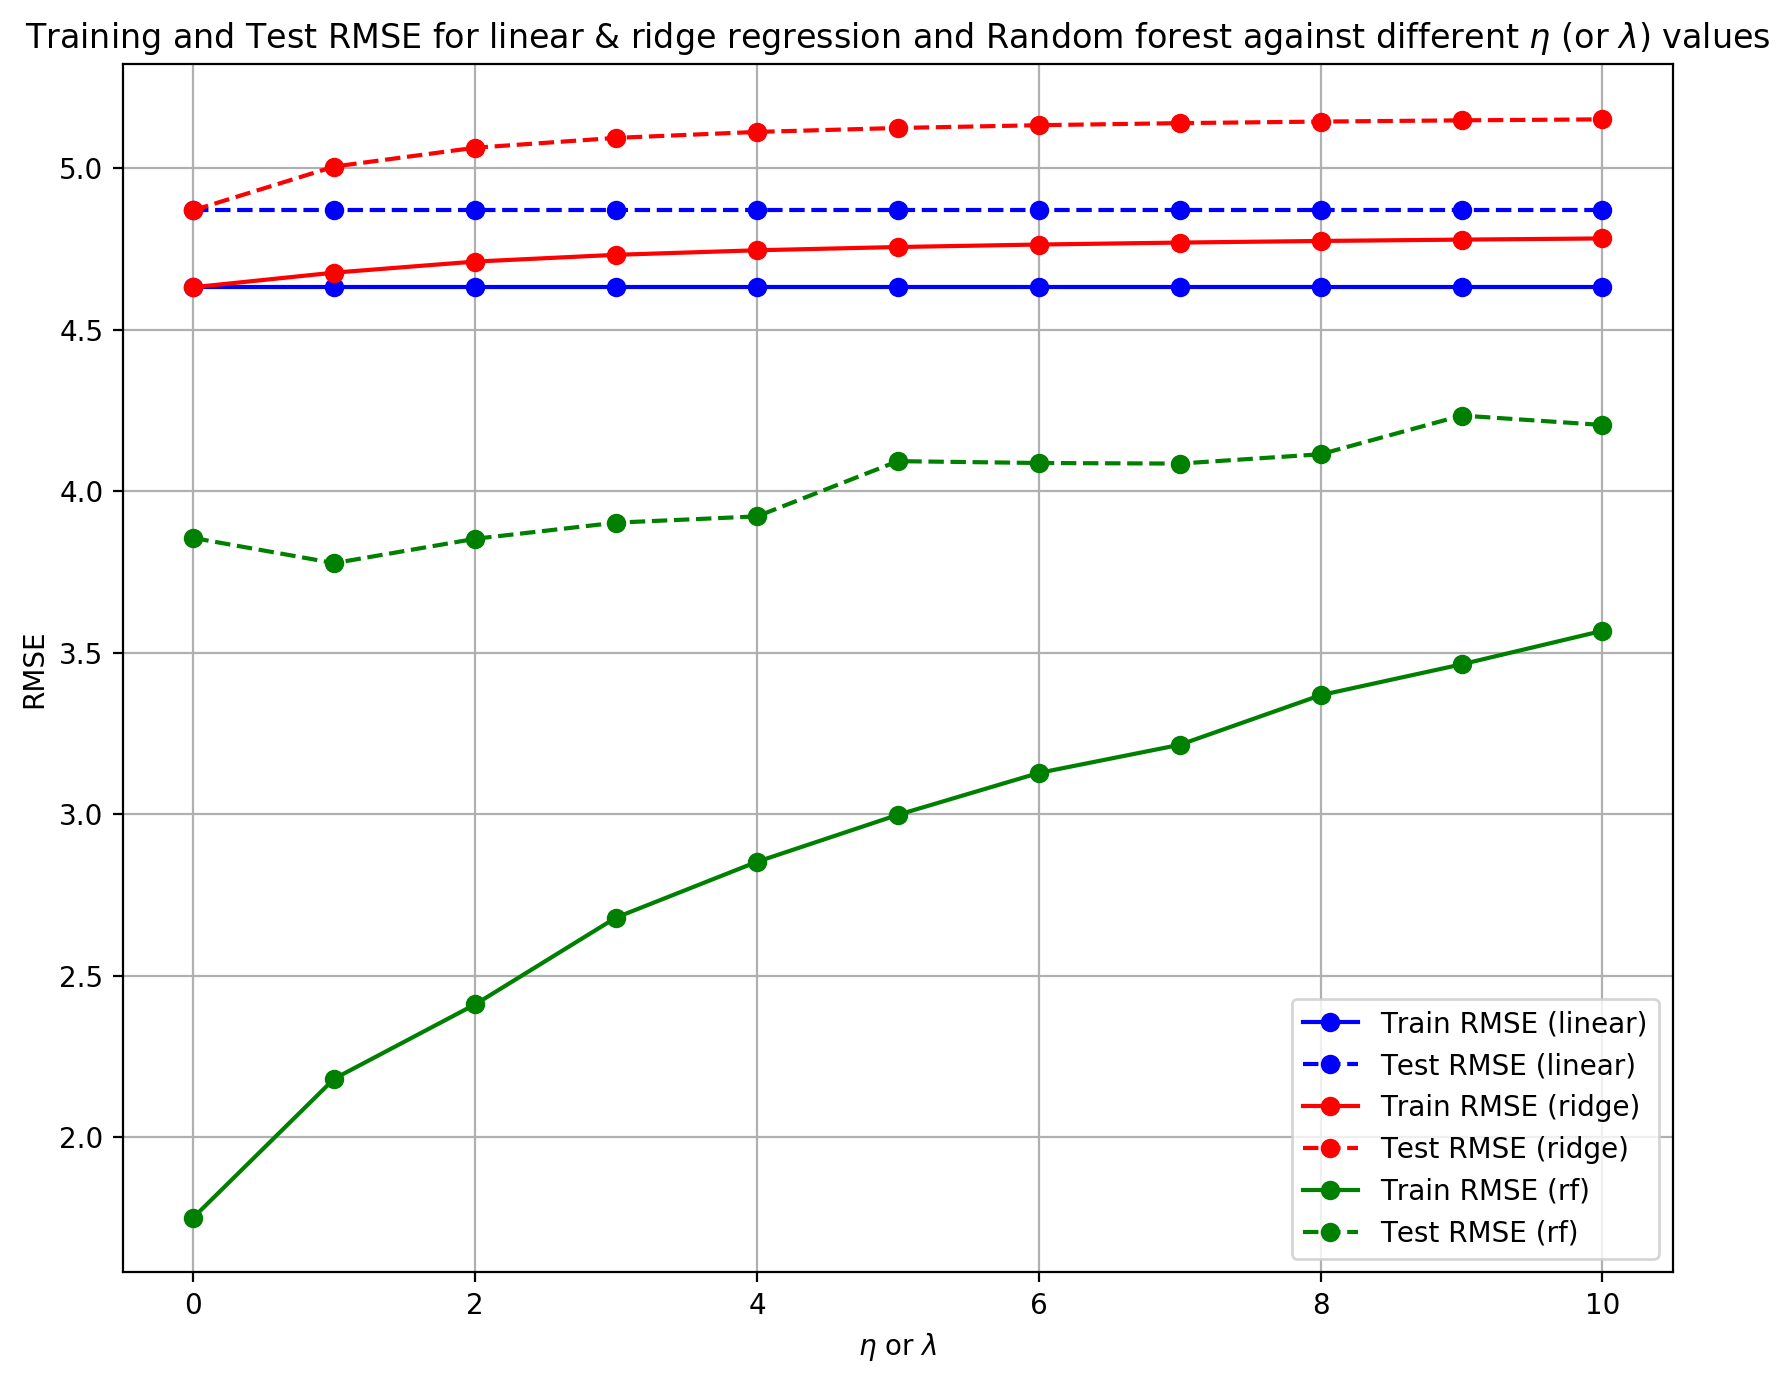

In [907]:
# num_trees : 42, max_depth: 9, rf: 0.4, min_sample_split: 5, lambda: 1, gamma: 0.4

etas = [i for i in range(0,11,1)]

rmse_train_linear = []
rmse_test_linear = []
rmse_train_ridge = []
rmse_test_ridge = []
rmse_train_rf = []
rmse_test_rf = []

for eta in etas:
    theta = least_square(boston_X_train, boston_y_train)
    theta_r = ridge_reg(boston_X_train, boston_y_train, eta)
    
    rf_model = RF(loss='mse',max_depth=9, min_sample_split=15, lamda=eta,
                  gamma=0.4, num_trees=42, rf=0.4, parallelize=False)
    rf_model.fit(boston_X_train, boston_y_train)
    train_pred = rf_model.predict(boston_X_train)
    train_rmse = root_mean_square_error(train_pred, boston_y_train)
    test_pred = rf_model.predict(boston_X_test)
    test_rmse = root_mean_square_error(test_pred, boston_y_test)
    rmse_train_rf.append(train_rmse)
    rmse_test_rf.append(test_rmse)
    
    pred_y_train_lin = pred_fn(boston_X_train, theta)
    pred_y_test_lin = pred_fn(boston_X_test, theta)
    rmse_train_linear.append(root_mean_square_error(pred_y_train_lin, boston_y_train))
    rmse_test_linear.append(root_mean_square_error(pred_y_test_lin, boston_y_test))
    
    pred_y_train_r = pred_fn(boston_X_train, theta_r)
    pred_y_test_r = pred_fn(boston_X_test, theta_r)
    rmse_train_ridge.append(root_mean_square_error(pred_y_train_r, boston_y_train))
    rmse_test_ridge.append(root_mean_square_error(pred_y_test_r, boston_y_test))
    
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
plt.plot(etas, rmse_train_linear, '-o', c = 'blue', ls = '-', label = 'Train RMSE (linear)')
plt.plot(etas, rmse_test_linear, '-o', c = 'blue', ls = '--', label = 'Test RMSE (linear)')
plt.plot(etas, rmse_train_ridge, '-o', c = 'red', ls = '-', label = 'Train RMSE (ridge)')
plt.plot(etas, rmse_test_ridge, '-o', c = 'red', ls = '--',label = 'Test RMSE (ridge)')
plt.plot(etas, rmse_train_rf, '-o', c = 'g', ls = '-',label = 'Train RMSE (rf)')
plt.plot(etas, rmse_test_rf, '-o', c = 'g', ls = '--',label = 'Test RMSE (rf)')

plt.grid()
plt.title("Training and Test RMSE for linear & ridge regression and Random forest against different $\eta$ (or $\lambda$) values")
plt.legend()
plt.xlabel('$\eta$ or $\lambda$')
plt.ylabel('RMSE')

### credit_g classification task  (RF)

num of trees 30, Acc: 0.6857142857142857
num of trees 34, Acc: 0.7
num of trees 38, Acc: 0.7
num of trees 42, Acc: 0.6857142857142857
num of trees 46, Acc: 0.7285714285714285
num of trees 50, Acc: 0.7


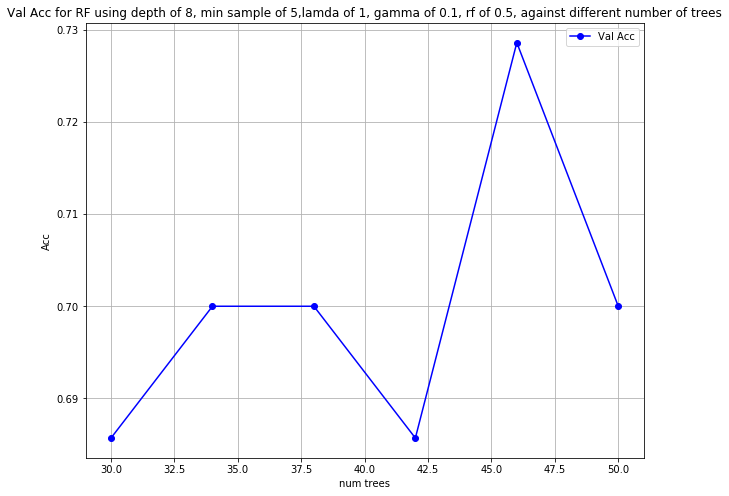

Max depth 5, Acc: 0.6857142857142857
Max depth 6, Acc: 0.6714285714285714
Max depth 7, Acc: 0.7285714285714285
Max depth 8, Acc: 0.6857142857142857
Max depth 9, Acc: 0.7571428571428571
Max depth 10, Acc: 0.7142857142857143


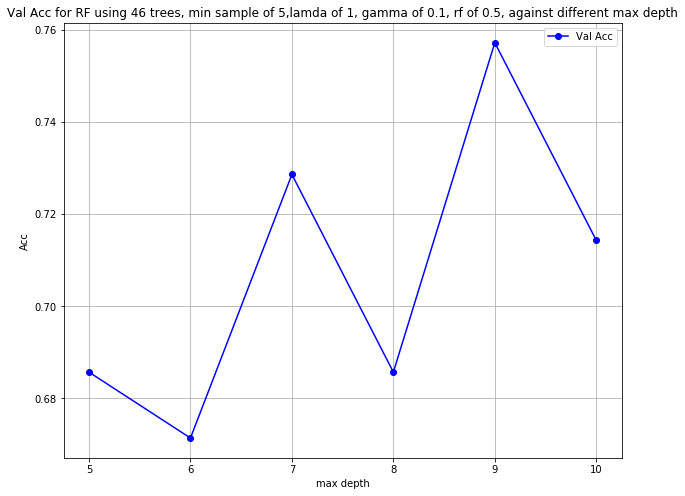

rf 0.3, Acc: 0.7142857142857143
rf 0.4, Acc: 0.6857142857142857
rf 0.5, Acc: 0.7285714285714285


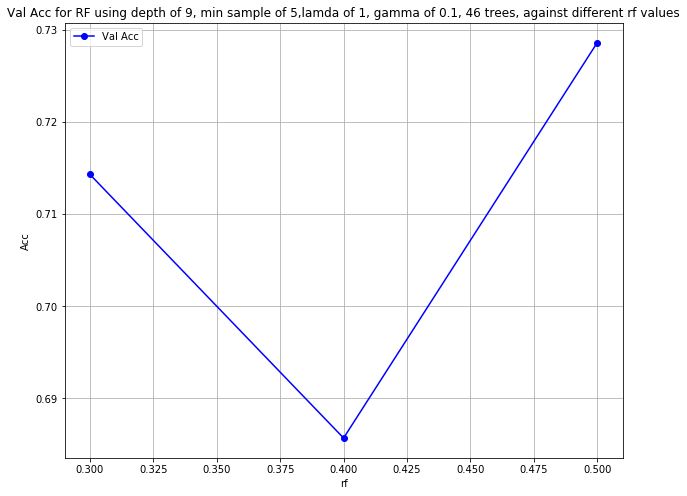

min_sample_split 1, Acc: 0.7142857142857143
min_sample_split 2, Acc: 0.7
min_sample_split 3, Acc: 0.7
min_sample_split 5, Acc: 0.6714285714285714
min_sample_split 10, Acc: 0.7142857142857143
min_sample_split 15, Acc: 0.7142857142857143


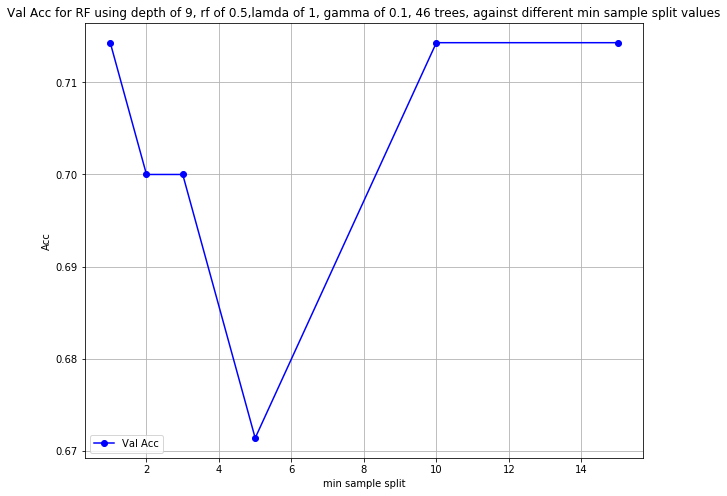

lambda 1, Acc: 0.7142857142857143
lambda 2, Acc: 0.7142857142857143
lambda 3, Acc: 0.7714285714285715
lambda 4, Acc: 0.7857142857142857
lambda 5, Acc: 0.8
lambda 6, Acc: 0.7857142857142857
lambda 7, Acc: 0.7714285714285715
lambda 8, Acc: 0.7857142857142857
lambda 9, Acc: 0.7714285714285715
lambda 10, Acc: 0.7571428571428571


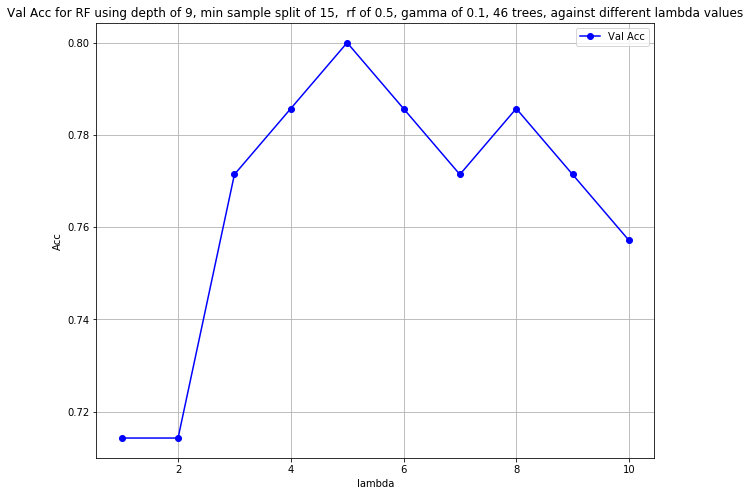

gamma 0.1, Acc: 0.8
gamma 0.2, Acc: 0.7857142857142857
gamma 0.30000000000000004, Acc: 0.7714285714285715
gamma 0.4, Acc: 0.7571428571428571
gamma 0.5, Acc: 0.7857142857142857
gamma 0.6, Acc: 0.7857142857142857
gamma 0.7000000000000001, Acc: 0.7857142857142857
gamma 0.8, Acc: 0.7857142857142857
gamma 0.9, Acc: 0.7571428571428571
gamma 1.0, Acc: 0.7857142857142857


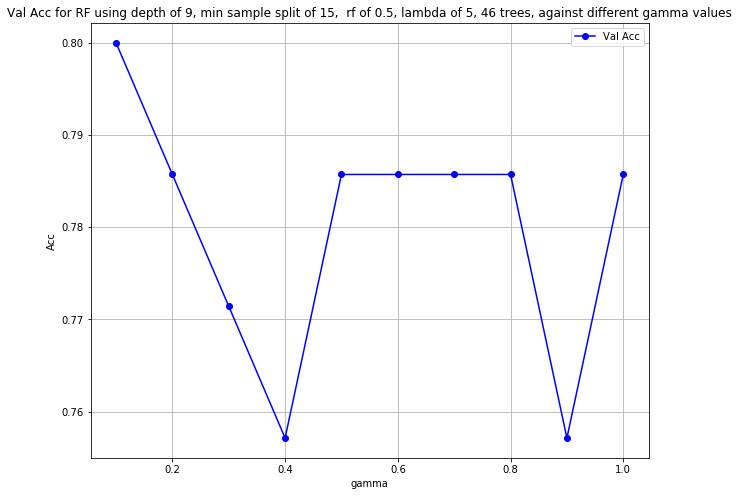

Selected values: num_trees : 46, max_depth: 9, rf: 0.5, min_sample_split: 15, lambda: 5, gamma: 0.1


In [877]:
# hyper-parameter tuning

lamdas = [i for i in range(1,11)]
gammas = [i for i in np.arange(0.1, 1.1, 0.1)]
max_depths = [i for i in range(5, 11, 1)]
min_sample_splits = [1,2,3] + [i for i in range(5, 20, 5)]
num_treess = [i for i in range(30,51,4)]
rfs = [0.2, 0.3, 0.4, 0.5]


credit_X_train_mod, credit_X_test_mod, credit_y_train_mod, credit_y_test_mod = train_test_split(credit_X_train, credit_y_train, test_size=0.1, random_state=8)
max_depth = 8
min_sample_split = 5
lamda = 1
gamma = 0.1
rf = 0.5

records = []
for num_tree in num_treess:
    rf_model = RF(loss='logistic',max_depth=max_depth, min_sample_split=min_sample_split, lamda=lamda,
                  gamma=gamma,num_trees=num_tree,rf=rf, parallelize=False)
    rf_model.fit(credit_X_train_mod, credit_y_train_mod)
    pred = rf_model.predict(credit_X_test_mod)
    Acc = accuracy(pred, credit_y_test_mod)
    print (f'num of trees {num_tree}, Acc: {Acc}')
    records.append([num_tree, Acc])
    
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot([x[0] for x in records], [x[1] for x in records], '-o', c = 'blue', ls = '-', label = 'Val Acc')
plt.grid()
plt.title(f"Val Acc for RF using depth of {max_depth}, min sample of {min_sample_split},lamda of {lamda}, gamma of {gamma}, rf of {rf}, against different number of trees")
plt.legend()
plt.xlabel('num trees')
plt.ylabel('Acc')
plt.show()    


sorted_records = sorted(records, key=operator.itemgetter(1))
num_tree = sorted_records[-1][0]
records = []
for max_depth in max_depths:
    rf_model = RF(loss='logistic',max_depth=max_depth, min_sample_split=min_sample_split, lamda=lamda,
                  gamma=gamma,num_trees=num_tree,rf=rf, parallelize=False)
    rf_model.fit(credit_X_train_mod, credit_y_train_mod)
    pred = rf_model.predict(credit_X_test_mod)
    Acc = accuracy(pred, credit_y_test_mod)
    print (f'Max depth {max_depth}, Acc: {Acc}')
    records.append([max_depth, Acc])
    
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot([x[0] for x in records], [x[1] for x in records], '-o', c = 'blue', ls = '-', label = 'Val Acc')
plt.grid()
plt.title(f"Val Acc for RF using {num_tree} trees, min sample of {min_sample_split},lamda of {lamda}, gamma of {gamma}, rf of {rf}, against different max depth")
plt.legend()
plt.xlabel('max depth')
plt.ylabel('Acc')
plt.show()    


sorted_records = sorted(records, key=operator.itemgetter(1))
max_depth = sorted_records[-1][0]
records = []
for rf in rfs:
    rf_model = RF(loss='logistic',max_depth=max_depth, min_sample_split=min_sample_split, lamda=lamda,
                  gamma=gamma,num_trees=num_tree,rf=rf, parallelize=False)
    rf_model.fit(credit_X_train_mod, credit_y_train_mod)
    pred = rf_model.predict(credit_X_test_mod)
    Acc = accuracy(pred, credit_y_test_mod)
    print (f'rf {rf}, Acc: {Acc}')
    records.append([rf, Acc])

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot([x[0] for x in records], [x[1] for x in records], '-o', c = 'blue', ls = '-', label = 'Val Acc')
plt.grid()
plt.title(f"Val Acc for RF using depth of {max_depth}, min sample of {min_sample_split},lamda of {lamda}, gamma of {gamma}, {num_tree} trees, against different rf values")
plt.legend()
plt.xlabel('rf')
plt.ylabel('Acc')
plt.show() 


sorted_records = sorted(records, key=operator.itemgetter(1))
rf = sorted_records[-1][0]
records = []

for min_sample_split in min_sample_splits:
    rf_model = RF(loss='logistic',max_depth=max_depth, min_sample_split=min_sample_split, lamda=lamda,
                  gamma=gamma,num_trees=num_tree,rf=rf, parallelize=False)
    rf_model.fit(credit_X_train_mod, credit_y_train_mod)
    pred = rf_model.predict(credit_X_test_mod)
    Acc = accuracy(pred, credit_y_test_mod)
    print (f'min_sample_split {min_sample_split}, Acc: {Acc}')
    records.append([min_sample_split, Acc])
   
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot([x[0] for x in records], [x[1] for x in records], '-o', c = 'blue', ls = '-', label = 'Val Acc')
plt.grid()
plt.title(f"Val Acc for RF using depth of {max_depth}, rf of {rf},lamda of {lamda}, gamma of {gamma}, {num_tree} trees, against different min sample split values")
plt.legend()
plt.xlabel('min sample split')
plt.ylabel('Acc')
plt.show()    



sorted_records = sorted(records, key=operator.itemgetter(1))
min_sample_split = sorted_records[-1][0]
records = []

for lamda in lamdas:
    rf_model = RF(loss='logistic',max_depth=max_depth, min_sample_split=min_sample_split, lamda=lamda,
                  gamma=gamma,num_trees=num_tree,rf=rf, parallelize=False)
    rf_model.fit(credit_X_train_mod, credit_y_train_mod)
    pred = rf_model.predict(credit_X_test_mod)
    Acc = accuracy(pred, credit_y_test_mod)
    print (f'lambda {lamda}, Acc: {Acc}')
    records.append([lamda, Acc])

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot([x[0] for x in records], [x[1] for x in records], '-o', c = 'blue', ls = '-', label = 'Val Acc')
plt.grid()
plt.title(f"Val Acc for RF using depth of {max_depth}, min sample split of {min_sample_split},  rf of {rf}, gamma of {gamma}, {num_tree} trees, against different lambda values")
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Acc')
plt.show()


sorted_records = sorted(records, key=operator.itemgetter(1))
lamda = sorted_records[-1][0]
records = []

for gamma in gammas:
    rf_model = RF(loss='logistic',max_depth=max_depth, min_sample_split=min_sample_split, lamda=lamda,
                  gamma=gamma,num_trees=num_tree,rf=rf, parallelize=False)
    rf_model.fit(credit_X_train_mod, credit_y_train_mod)
    pred = rf_model.predict(credit_X_test_mod)
    Acc = accuracy(pred, credit_y_test_mod)
    print (f'gamma {gamma}, Acc: {Acc}')
    records.append([gamma, Acc])
    
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot([x[0] for x in records], [x[1] for x in records], '-o', c = 'blue', ls = '-', label = 'Val Acc')
plt.grid()
plt.title(f"Val Acc for RF using depth of {max_depth}, min sample split of {min_sample_split},  rf of {rf}, lambda of {lamda}, {num_tree} trees, against different gamma values")
plt.legend()
plt.xlabel('gamma')
plt.ylabel('Acc')
plt.show()

sorted_records = sorted(records, key=operator.itemgetter(1))
gamma = sorted_records[-1][0]

print (f"Selected values: num_trees : {num_tree}, max_depth: {max_depth}, rf: {rf}, min_sample_split: {min_sample_split}, lambda: {lamda}, gamma: {gamma}")




In [908]:
# Selected values: num_trees : 46, max_depth: 9, rf: 0.5, min_sample_split: 5, lambda: 5, gamma: 0.1

rf_model = RF(loss='logistic', max_depth=9, min_sample_split=5, lamda=5,
                  gamma=0.1, num_trees=46, rf=0.5, parallelize=False)
rf_model.fit(credit_X_train, credit_y_train)
train_pred = rf_model.predict(credit_X_train)
train_acc = accuracy(train_pred, credit_y_train)

test_pred = rf_model.predict(credit_X_test)
test_acc = accuracy(test_pred, credit_y_test)

print (f"Train Accuracy: {train_acc}, Test accuracy: {test_acc}")

Train Accuracy: 0.8414285714285714, Test accuracy: 0.7766666666666666


### Breast cancer classification task (RF)

In [909]:
# Selected values: num_trees : 50, max_depth: 9, rf: 0.5, min_sample_split: 2, lambda: 1, gamma: 0.30000000000000004

rf_model = RF(loss='logistic', max_depth=9, min_sample_split=2, lamda=1,
              gamma=0.3, num_trees=50, rf=0.5)

rf_model.fit(cancer_X_train, cancer_y_train)
train_pred = rf_model.predict(cancer_X_train)
train_acc = accuracy(train_pred, cancer_y_train)
test_pred = rf_model.predict(cancer_X_test)
test_acc = accuracy(test_pred, cancer_y_test)
print (f"Train accuracy: {train_acc}, Test Accuracy: {test_acc}")

Train accuracy: 0.992462311557789, Test Accuracy: 0.9590643274853801


## GBDT Model - Training & Inference

### Boston regression task (GBDT)

In [915]:
# Selected values: num_trees : 42, max_depth: 6, lr: 0.1, min_sample_split: 3, lambda: 1, gamma: 0.1

gbdt_model = GBDT(loss='mse',max_depth=6, min_sample_split=3, lamda=1,
                  gamma=0.1, num_trees=42, learning_rate=0.1, parallelize=False)
gbdt_model.fit(boston_X_train, boston_y_train)
train_pred = gbdt_model.predict(boston_X_train)
train_rmse = root_mean_square_error(train_pred, boston_y_train)

test_pred =gbdt_model.predict(boston_X_test)
test_rmse = root_mean_square_error(test_pred, boston_y_test)

print (f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")


Train RMSE: 0.6880085715608592, Test RMSE: 3.5259275598906963


Text(0, 0.5, 'RMSE')

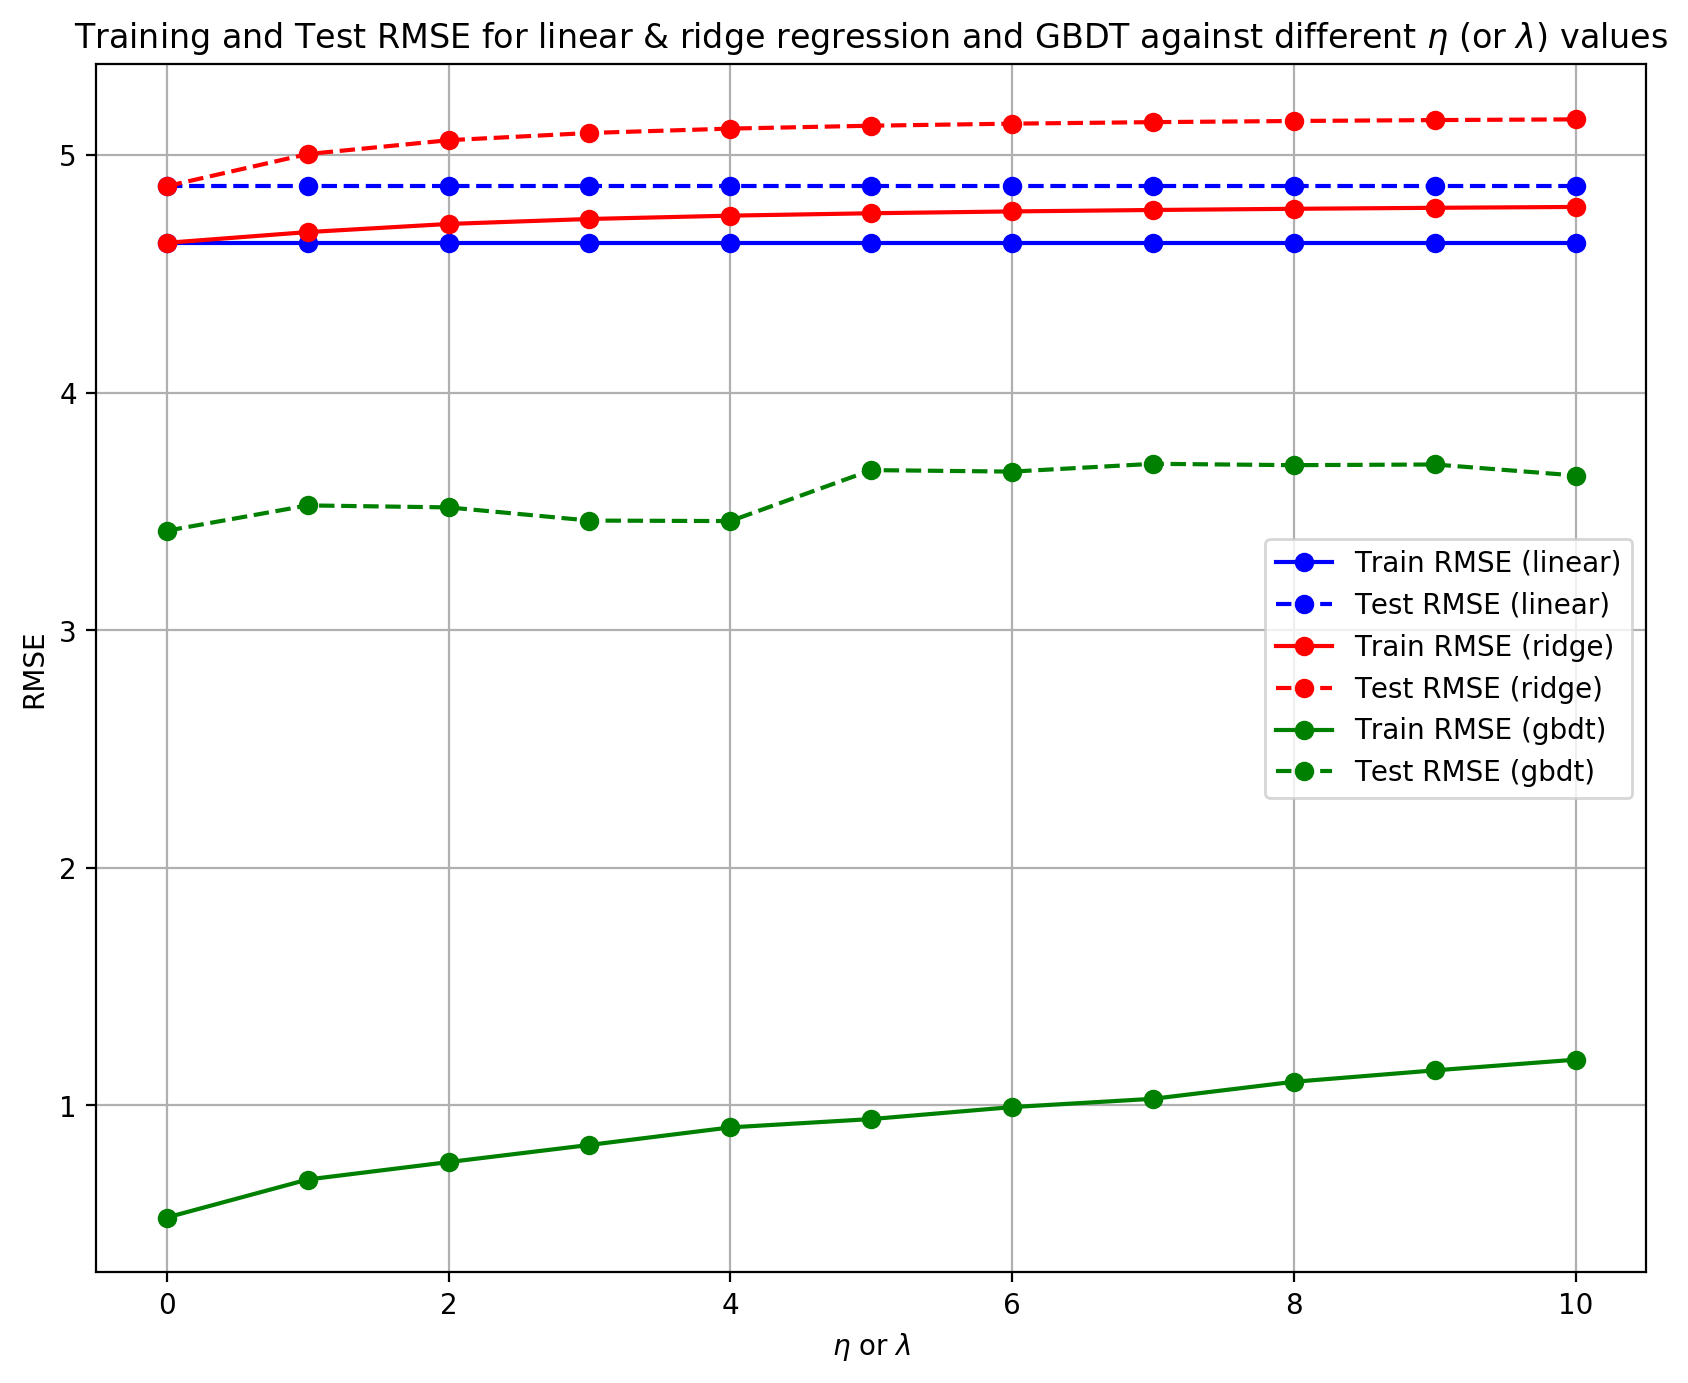

In [933]:
# Selected values: num_trees : 42, max_depth: 6, lr: 0.1, min_sample_split: 3, lambda: 1, gamma: 0.1

etas = [i for i in range(0,11,1)]

rmse_train_linear = []
rmse_test_linear = []
rmse_train_ridge = []
rmse_test_ridge = []
rmse_train_gbdt = []
rmse_test_gbdt = []

for eta in etas:
    theta = least_square(boston_X_train, boston_y_train)
    theta_r = ridge_reg(boston_X_train, boston_y_train, eta)
    
    gbdt_model = GBDT(loss='mse',max_depth=6, min_sample_split=3, lamda=eta,
                  gamma=0.1, num_trees=42, learning_rate=0.1, parallelize=False)
    gbdt_model.fit(boston_X_train, boston_y_train)
    train_pred = gbdt_model.predict(boston_X_train)
    train_rmse = root_mean_square_error(train_pred, boston_y_train)
    test_pred = gbdt_model.predict(boston_X_test)
    test_rmse = root_mean_square_error(test_pred, boston_y_test)
    rmse_train_gbdt.append(train_rmse)
    rmse_test_gbdt.append(test_rmse)
    
    pred_y_train_lin = pred_fn(boston_X_train, theta)
    pred_y_test_lin = pred_fn(boston_X_test, theta)
    rmse_train_linear.append(root_mean_square_error(pred_y_train_lin, boston_y_train))
    rmse_test_linear.append(root_mean_square_error(pred_y_test_lin, boston_y_test))
    
    pred_y_train_r = pred_fn(boston_X_train, theta_r)
    pred_y_test_r = pred_fn(boston_X_test, theta_r)
    rmse_train_ridge.append(root_mean_square_error(pred_y_train_r, boston_y_train))
    rmse_test_ridge.append(root_mean_square_error(pred_y_test_r, boston_y_test))
    
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
plt.plot(etas, rmse_train_linear, '-o', c = 'blue', ls = '-', label = 'Train RMSE (linear)')
plt.plot(etas, rmse_test_linear, '-o', c = 'blue', ls = '--', label = 'Test RMSE (linear)')
plt.plot(etas, rmse_train_ridge, '-o', c = 'red', ls = '-', label = 'Train RMSE (ridge)')
plt.plot(etas, rmse_test_ridge, '-o', c = 'red', ls = '--',label = 'Test RMSE (ridge)')
plt.plot(etas, rmse_train_gbdt, '-o', c = 'g', ls = '-',label = 'Train RMSE (gbdt)')
plt.plot(etas, rmse_test_gbdt, '-o', c = 'g', ls = '--',label = 'Test RMSE (gbdt)')

plt.grid()
plt.title("Training and Test RMSE for linear & ridge regression and GBDT against different $\eta$ (or $\lambda$) values")
plt.legend()
plt.xlabel('$\eta$ or $\lambda$')
plt.ylabel('RMSE')

### Credit_g classification task (GBDT)

In [913]:
# Selected values: num_trees : 50, max_depth: 10, lr: 0.1, min_sample_split: 3, lambda: 2, gamma: 0.2

gbdt_model = GBDT(loss='logistic',max_depth=10, min_sample_split=3, lamda=2,
                  gamma=0.2, num_trees=50, learning_rate=0.1, parallelize=False)
gbdt_model.fit(credit_X_train, credit_y_train)
train_pred = gbdt_model.predict(credit_X_train)
train_acc = accuracy(train_pred, credit_y_train)

test_pred =gbdt_model.predict(credit_X_test)
test_acc = accuracy(test_pred, credit_y_test)

print (f"Train Accuracy: {train_acc}, Test accuracy: {test_acc}")

Train Accuracy: 0.9928571428571429, Test accuracy: 0.81


### breast cancer classification task (GBDT)

In [917]:
# Selected values: num_trees : 50, max_depth: 10, lr: 0.8, min_sample_split: 15, lambda: 4, gamma: 0.30000000000000004

gbdt_model = GBDT(loss='logistic',max_depth=10, min_sample_split=15, lamda=4,
                  gamma=0.3, num_trees=50, learning_rate=0.8, parallelize=False)
gbdt_model.fit(cancer_X_train, cancer_y_train)
train_pred = gbdt_model.predict(cancer_X_train)
train_acc = accuracy(train_pred, cancer_y_train)

test_pred =gbdt_model.predict(cancer_X_test)
test_acc = accuracy(test_pred, cancer_y_test)

print (f"Train Accuracy: {train_acc}, Test accuracy: {test_acc}")

Train Accuracy: 0.9949748743718593, Test accuracy: 0.9707602339181286
